In [26]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import vaex
from vaex.dataframe import DataFrame
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dmsp-particle-precipitate-flux/AI_Ready_DMSP_Data.csv
/kaggle/input/particle-flux-prediction-dataset-small/AI_Ready_DMSP_Data.csv.crdownload


In [2]:
%%time
df = pd.read_csv("/kaggle/input/particle-flux-prediction-dataset-small/AI_Ready_DMSP_Data.csv.crdownload")

CPU times: user 210 ms, sys: 52.6 ms, total: 263 ms
Wall time: 447 ms


## Data Understanding and pre-processing

In [3]:
df.shape

(6828, 154)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6828 entries, 0 to 6827
Columns: 154 entries, Datetimes to newell_5min
dtypes: float64(153), object(1)
memory usage: 8.0+ MB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SC_AACGM_LAT,6828.0,6.623694e+01,1.058720e+01,4.501050e+01,5.795416e+01,6.754129e+01,7.428236e+01,8.946862e+01
SC_AACGM_LTIME,6828.0,1.261739e+01,6.383255e+00,3.137616e-03,7.954506e+00,1.117522e+01,1.885893e+01,2.399197e+01
ELE_TOTAL_ENERGY_FLUX,6828.0,6.609118e+10,8.469603e+11,6.229923e+06,2.179984e+08,7.486856e+08,1.844837e+10,6.019487e+13
ELE_TOTAL_ENERGY_FLUX_STD,6828.0,4.228732e-01,4.703586e-01,6.363267e-02,1.525149e-01,2.826462e-01,5.212378e-01,6.791971e+00
ELE_AVG_ENERGY,6828.0,9.423338e+02,2.741773e+03,3.000000e+01,4.943325e+01,1.182965e+02,5.308267e+02,3.000000e+04
...,...,...,...,...,...,...,...,...
vsw_5min,6827.0,3.902693e+02,5.071063e+01,2.804000e+02,3.563000e+02,3.862000e+02,4.121000e+02,6.744000e+02
vx_5min,6827.0,-3.890447e+02,5.093798e+01,-6.711000e+02,-4.115000e+02,-3.842000e+02,-3.550000e+02,-2.790000e+02
psw_5min,6827.0,2.134615e+00,1.249924e+00,2.800000e-01,1.260000e+00,1.680000e+00,2.750000e+00,9.740000e+00
borovsky_5min,6827.0,1.826616e+04,1.764378e+04,4.770848e-02,4.820545e+03,1.406102e+04,2.608820e+04,9.939165e+04


In [6]:
df.corr()

,SC_AACGM_LAT,SC_AACGM_LTIME,ELE_TOTAL_ENERGY_FLUX,ELE_TOTAL_ENERGY_FLUX_STD,ELE_AVG_ENERGY,ELE_AVG_ENERGY_STD,ID_SC,sin_ut,cos_ut,sin_doy,...,AE_5min,AL_5min,AU_5min,SymH_5min,PC_5min,vsw_5min,vx_5min,psw_5min,borovsky_5min,newell_5min
SC_AACGM_LAT,1.000000,-0.077137,0.011166,-0.217543,-0.036369,-0.203636,0.029454,-0.053126,-0.031444,0.123176,...,-0.005325,-0.007701,-0.026401,0.022509,0.021169,-0.002800,0.000848,-0.008444,0.026161,0.042876
SC_AACGM_LTIME,-0.077137,1.000000,-0.025051,-0.008799,-0.127105,-0.006429,0.048726,-0.110258,0.026450,-0.056365,...,0.037789,-0.032912,0.034571,0.034059,0.022497,-0.029887,0.028628,0.030849,0.011966,0.010927
ELE_TOTAL_ENERGY_FLUX,0.011166,-0.025051,1.000000,-0.045956,0.125707,-0.044610,-0.006837,0.031414,-0.003450,0.025544,...,0.043323,-0.041015,0.034244,-0.035007,0.048553,0.006667,-0.006714,0.005607,0.025117,0.040879
ELE_TOTAL_ENERGY_FLUX_STD,-0.217543,-0.008799,-0.045956,1.000000,0.249302,0.980391,-0.114982,0.003274,0.020736,0.089033,...,0.006769,0.009655,0.033339,-0.041813,0.005550,0.018336,-0.019046,-0.064218,-0.013703,0.012754
ELE_AVG_ENERGY,-0.036369,-0.127105,0.125707,0.249302,1.000000,0.233580,-0.108567,0.007714,0.023762,0.074690,...,0.036063,-0.025877,0.042878,-0.066974,0.053353,0.040892,-0.041470,-0.034040,-0.019942,0.009034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vsw_5min,-0.002800,-0.029887,0.006667,0.018336,0.040892,-0.001718,-0.174585,0.021817,-0.019749,-0.112679,...,-0.033241,-0.031657,-0.137261,-0.011167,-0.105444,1.000000,-0.999629,0.088055,0.077025,-0.060439
vx_5min,0.000848,0.028628,-0.006714,-0.019046,-0.041470,0.001374,0.178999,-0.012455,0.015875,0.108676,...,0.030698,0.034489,0.136009,0.007022,0.102419,-0.999629,1.000000,-0.093742,-0.082966,0.060337
psw_5min,-0.008444,0.030849,0.005607,-0.064218,-0.034040,-0.094770,-0.139832,-0.185773,0.094902,-0.307164,...,0.169941,-0.136025,0.177299,0.410952,-0.021852,0.088055,-0.093742,1.000000,0.425844,-0.101076
borovsky_5min,0.026161,0.011966,0.025117,-0.013703,-0.019942,-0.033696,-0.142067,-0.168537,-0.054905,-0.117401,...,0.294366,-0.299943,0.195702,0.047589,0.254863,0.077025,-0.082966,0.425844,1.000000,0.567923


In [7]:
df['ELE_TOTAL_ENERGY_FLUX']

0       2.057827e+08
1       2.509837e+08
2       4.469146e+08
3       1.934849e+10
4       3.913337e+11
            ...     
6823    2.240820e+08
6824    2.240820e+08
6825    4.652076e+09
6826    3.049135e+10
6827    8.756798e+09
Name: ELE_TOTAL_ENERGY_FLUX, Length: 6828, dtype: float64

In [8]:
df.select_dtypes('object')

,Datetimes
0,1987-01-12 12:57:00
1,1987-01-12 12:58:00
2,1987-01-12 13:01:00
3,1987-01-12 13:02:00
4,1987-01-12 13:03:00
...,...
6823,2001-02-28 10:12:00
6824,2001-02-28 10:13:00
6825,2001-02-28 10:14:00
6826,2001-02-28 10:15:00


### Datetime conversion

In [9]:
df['Datetimes'] = pd.to_datetime(df['Datetimes'], format='%Y-%m-%d')
df['Datetimes']

0      1987-01-12 12:57:00
1      1987-01-12 12:58:00
2      1987-01-12 13:01:00
3      1987-01-12 13:02:00
4      1987-01-12 13:03:00
               ...        
6823   2001-02-28 10:12:00
6824   2001-02-28 10:13:00
6825   2001-02-28 10:14:00
6826   2001-02-28 10:15:00
6827   2001-02-28 10:16:00
Name: Datetimes, Length: 6828, dtype: datetime64[ns]

<AxesSubplot:ylabel='Frequency'>

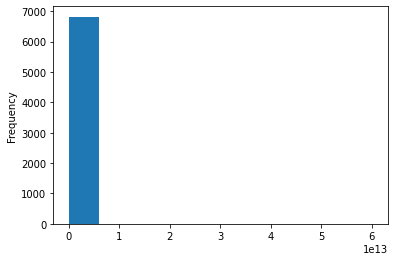

In [10]:
df['ELE_TOTAL_ENERGY_FLUX'].plot(kind='hist')

- Number format is large so we have to convert it to logarithmic form

### Taking a log of target variable

In [11]:
df['ELE_TOTAL_ENERGY_FLUX'] = np.log10(df['ELE_TOTAL_ENERGY_FLUX'])
df['ELE_TOTAL_ENERGY_FLUX']

0        8.313409
1        8.399646
2        8.650225
3       10.286647
4       11.592547
          ...    
6823     8.350407
6824     8.350407
6825     9.667647
6826    10.484177
6827     9.942345
Name: ELE_TOTAL_ENERGY_FLUX, Length: 6828, dtype: float64

In [12]:
# remove datetimes columns as time is not related to our context
X = df.drop(['Datetimes','ELE_TOTAL_ENERGY_FLUX'], axis=1)
y = df['ELE_TOTAL_ENERGY_FLUX']

In [13]:
new_lst = list(y)
lst = new_lst[:6827]
y_n = pd.Series(lst)
y_n

0        8.313409
1        8.399646
2        8.650225
3       10.286647
4       11.592547
          ...    
6822     8.065772
6823     8.350407
6824     8.350407
6825     9.667647
6826    10.484177
Length: 6827, dtype: float64

In [14]:
# standardize the dataset
sc = StandardScaler()
sc.fit(X)
X_n = sc.transform(X)
features = sc.get_feature_names_out()
X_n = pd.DataFrame(X_n, columns=features)

In [15]:
# find the rows with missing values
X_n[X_n.isnull().any(axis=1)]

,SC_AACGM_LAT,SC_AACGM_LTIME,ELE_TOTAL_ENERGY_FLUX_STD,ELE_AVG_ENERGY,ELE_AVG_ENERGY_STD,ID_SC,sin_ut,cos_ut,sin_doy,cos_doy,...,AE_5min,AL_5min,AU_5min,SymH_5min,PC_5min,vsw_5min,vx_5min,psw_5min,borovsky_5min,newell_5min
6827,0.714619,-1.313764,-0.445427,-0.248506,-0.408867,0.245297,0.82858,-1.38244,1.275739,0.121915,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
X_b = X_n.dropna(axis=0)
X_b.shape

(6827, 152)

## Feature selection using RFE

In [17]:
# features selection using RFE
estimtr = DecisionTreeRegressor()
selector = RFE(estimator=estimtr, n_features_to_select=30, step=2)
selector = selector.fit(X_b, y_n)
features = list(selector.get_feature_names_out())

In [18]:
features

['SC_AACGM_LAT',
 'SC_AACGM_LTIME',
 'ELE_TOTAL_ENERGY_FLUX_STD',
 'ELE_AVG_ENERGY',
 'ELE_AVG_ENERGY_STD',
 'ID_SC',
 'sin_ut',
 'cos_ut',
 'sin_doy',
 'cos_doy',
 'sin_SC_AACGM_LTIME',
 'cos_SC_AACGM_LTIME',
 'F107',
 'Bz',
 'AL',
 'newell',
 'F107_6hr',
 'Bx_6hr',
 'PC_6hr',
 'vx_6hr',
 'borovsky_6hr',
 'AL_5hr',
 'PC_5hr',
 'Bx_3hr',
 'psw_3hr',
 'borovsky_3hr',
 'vsw_1hr',
 'newell_1hr',
 'AE_5min',
 'psw_5min']

In [19]:
selector.get_params()

{'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'squared_error',
 'estimator__max_depth': None,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__random_state': None,
 'estimator__splitter': 'best',
 'estimator': DecisionTreeRegressor(),
 'importance_getter': 'auto',
 'n_features_to_select': 30,
 'step': 2,
 'verbose': 0}

- 30 Features have been selected from 152 features

## LGBM baseline model

In [20]:
# building lgbm model for regression
X_f = X_b[features]

# train and test split
X_trn, X_tst, y_trn, y_tst = train_test_split(X_f, y_n, test_size=0.20, random_state=42)

# modeling stage
regressor = LGBMRegressor(learning_rate=0.01,random_state=42)
regressor.fit(X_trn, y_trn)

LGBMRegressor(learning_rate=0.01, random_state=42)

In [21]:
# predict on test data
preds = regressor.predict(X_tst)

# evaluation metrics
rmse = np.sqrt(mean_squared_error(y_tst, preds))
r2 = r2_score(y_tst,preds)
print("RMSE:", rmse)
print("R2_score:", r2)

RMSE: 0.5400760455216901
R2_score: 0.7995418857637542


# Neural network model

In [24]:
# NN model for regression task
model = Sequential()
model.add(Dense(256, kernel_initializer='normal',input_dim = X_trn.shape[1], activation='relu'))

# The Hidden Layers :
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
model.add(Dense(1, kernel_initializer='normal',activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               7936      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 205,569
Trainable params: 205,569
Non-trainable params: 0
_________________________________________________________________


2023-01-04 12:21:05.852773: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [28]:
# compile the model 
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# model check point
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0)

callbacks_list = [checkpoint, earlystopping]

In [31]:
# fit the model 
model.fit(X_trn, y_trn, 
          epochs=100, 
          batch_size=128, 
          validation_data=(X_tst, y_tst), 
          callbacks=callbacks_list
         )

2023-01-04 12:38:45.351217: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
43/43 [==============================] - 1s 14ms/step - loss: 18.8518 - mean_squared_error: 18.8518 - val_loss: 1.6565 - val_mean_squared_error: 1.6565

Epoch 00001: val_loss improved from inf to 1.65647, saving model to Weights-001--1.65647.hdf5
Epoch 2/100
43/43 [==============================] - 0s 9ms/step - loss: 1.1281 - mean_squared_error: 1.1281 - val_loss: 0.8493 - val_mean_squared_error: 0.8493

Epoch 00002: val_loss improved from 1.65647 to 0.84925, saving model to Weights-002--0.84925.hdf5
Epoch 3/100
43/43 [==============================] - 0s 7ms/step - loss: 0.7008 - mean_squared_error: 0.7008 - val_loss: 0.6230 - val_mean_squared_error: 0.6230

Epoch 00003: val_loss improved from 0.84925 to 0.62304, saving model to Weights-003--0.62304.hdf5
Epoch 4/100
43/43 [==============================] - 0s 7ms/step - loss: 0.5105 - mean_squared_error: 0.5105 - val_loss: 0.4782 - val_mean_squared_error: 0.4782

Epoch 00004: val_loss improved from 0.62304 to 0.47818, sav

In [36]:
# predict on test data
predictions = model.predict(X_tst)

# evaluation metrics
rmse2 = np.sqrt(mean_squared_error(y_tst, predictions))
r22 = r2_score(y_tst,predictions)
print("RMSE:", rmse2)
print("R2_score:", r22)

RMSE: 0.38658343824990926
R2_score: 0.8972929396679128


## Model comparison

- Neural network performed much better than LightGBM baseline

> LightGBM model performance:

1. RMSE - 0.54
2. R2_score - 0.79

> Neural Network model performance:

1. RMSE - 0.38
2. R2_score - 0.89

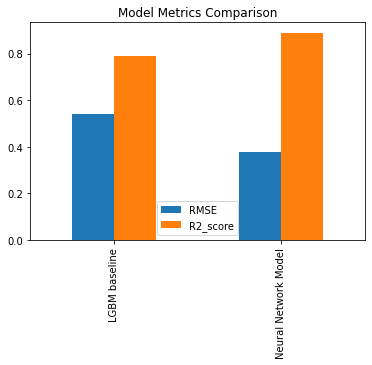

In [43]:
# Visualizing the the model performance
score_df = pd.DataFrame({'RMSE':[0.54,0.38],
                        'R2_score':[0.79,0.89]
                        }, index=['LGBM baseline','Neural Network Model']
                       )

# visualize the model metrics
score_df.plot(kind='bar', title='Model Metrics Comparison');